In [1]:
import numpy as np
import pandas as pd
import os
import scipy.linalg
from cmdstanpy import CmdStanModel
from sklearn.covariance import GraphicalLasso

expr = pd.read_csv("data/holland_rna_expr.tsv", index_col=0, sep="\t")
prior = pd.read_csv("data/tf_gene_matrix.csv", index_col=0)

/Users/chenyigang/.local/share/mamba/envs/RegInsight/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def prior_pp(prior, expr):
    """
    Filter low-confidence edges in the prior network using partial correlation.
    Similar to the R implementation using GeneNet.
    
    Parameters:
      prior: pd.DataFrame
          Prior regulatory network (adjacency matrix), rows are TFs, columns are target genes.
      expr: pd.DataFrame
          Normalized and log-transformed gene expression matrix, rows are genes.
    
    Returns:
      pd.DataFrame: Filtered prior network.
    """
    # Filter TFs and target genes that exist in the expression matrix
    tf = prior.index.intersection(expr.index)
    tg = prior.columns.intersection(expr.index)
    all_genes = np.unique(np.concatenate([tf, tg]))
    
    # Extract expression data for these genes (transposed like in R GeneNet)
    expr_sub = expr.loc[all_genes].T  # Samples × genes
    
    try:
        # Calculate correlation matrix
        corr_matrix = expr_sub.corr().values
        
        # Apply shrinkage to correlation matrix - similar to what GeneNet does
        n_genes = corr_matrix.shape[0]
        n_samples = expr_sub.shape[0]
        
        # Apply regularization to ensure positive definiteness
        shrinkage = min(0.2, 1/np.sqrt(n_samples))
        
        # Calculate shrunk correlation using Ledoit-Wolf like approach
        shrunk_corr = (1 - shrinkage) * corr_matrix + shrinkage * np.eye(n_genes)
        
        # Calculate approximate partial correlation using matrix inversion
        # This is similar to how GeneNet calculates it without graphical lasso
        try:
            # More numerically stable approach for matrix inversion
            precision_mat = scipy.linalg.pinvh(shrunk_corr)  # Pseudo-inverse for better stability
            
            # Convert precision to partial correlation
            diag_precision = np.sqrt(np.diag(precision_mat))
            partial_corr = -precision_mat / np.outer(diag_precision, diag_precision)
            np.fill_diagonal(partial_corr, 0)
        except:
            # If matrix inversion fails, fall back to just using the correlation
            print("Warning: Matrix inversion failed. Using correlation instead of partial correlation.")
            partial_corr = shrunk_corr
            np.fill_diagonal(partial_corr, 0)
        
    except Exception as e:
        print(f"Warning: Correlation calculation failed: {str(e)}. Using simpler approach.")
        # Fall back to a very simple correlation approach if all else fails
        corr_values = np.zeros((len(all_genes), len(all_genes)))
        
        # Calculate pairwise correlations manually if necessary
        for i, gene_i in enumerate(all_genes):
            for j, gene_j in enumerate(all_genes):
                if i != j:
                    try:
                        # Simple Pearson correlation
                        correlation = np.corrcoef(expr.loc[gene_i], expr.loc[gene_j])[0, 1]
                        corr_values[i, j] = correlation
                    except:
                        corr_values[i, j] = 0
        
        partial_corr = corr_values
    
    # Convert partial correlation coefficients to DataFrame
    coexp = pd.DataFrame(partial_corr, index=all_genes, columns=all_genes)
    
    # Take the part of the prior matrix that corresponds to the partial correlation submatrix
    P_ij = prior.loc[tf, tg].copy().astype(np.float64)  # Convert to float64 explicitly
    C_ij = coexp.loc[tf, tg] * P_ij.abs()
    
    # Compare the sign of prior edges and partial correlation
    sign_P = np.sign(P_ij)
    sign_C = np.sign(C_ij)
    
    # For edges with inconsistent signs, adjust the weight to a very small value (fuzzy)
    inconsistent = (sign_P * sign_C) < 0
    P_ij[inconsistent] = 1e-6
    
    # Remove all-zero TFs and genes
    P_ij = P_ij.loc[(P_ij != 0).any(axis=1), (P_ij != 0).any(axis=0)]
    return P_ij

In [ ]:
TFexpressed = True
signed = True

sample_name = expr.columns.tolist()
if TFexpressed:
    TF_names = sorted(list(set(prior.index).intersection(expr.index)))
else:
    TF_names = sorted(prior.index.tolist())
TG_names = sorted(list(set(expr.index).intersection(prior.columns)))
if len(TF_names) == 0 or len(TG_names) == 0:
    raise ValueError("Gene names in the input expression matrix do not match with the prior network.")

# 2. Prior network preprocessing (call prior_pp in signed case)
if signed:
    if set(TG_names).intersection(set(TF_names)):
        prior_sub = prior.loc[TF_names, TG_names].copy()
        prior_filtered = prior_pp(prior_sub, expr)
        prior_pp_python = prior_filtered.copy()
        if prior_filtered.shape[0] != len(TF_names):
            missing_tfs = set(TF_names) - set(prior_filtered.index)
            if missing_tfs:
                print(f"First few missing TFs: {list(missing_tfs)}")
                # 处理缺失的 TF
                TF_not_expressed_edge = prior.loc[list(missing_tfs), prior_filtered.columns]
                non_zero = TF_not_expressed_edge != 0
                TF_not_expressed_edge[non_zero] = np.sign(TF_not_expressed_edge[non_zero]) * 1e-6
                prior_filtered = pd.concat([prior_filtered, TF_not_expressed_edge])
                prior_filtered = prior_filtered.sort_index()
                print("After adding missing TFs - shape:", prior_filtered.shape)
                
                prior_filtered = prior_filtered.loc[(prior_filtered != 0).any(axis=1)]
                print("After removing all-zero rows - shape:", prior_filtered.shape)
        P = prior_filtered
        TF_names = list(P.index)
        TG_names = list(P.columns)
    else:
        P = prior.loc[TF_names, TG_names].copy()
else:
    P = prior.loc[TF_names, TG_names].copy()

First few missing TFs: ['ZNF79', 'MBD3', 'TRIM25']
After adding missing TFs - shape: (1170, 6356)
After removing all-zero rows - shape: (1165, 6356)


In [4]:
prior_pp_python

,A2M,A2ML1,A4GALT,AACS,AANAT,AAR2,AARS2,AATF,ABCA1,ABCA12,...,ZP1,ZP2,ZP3,ZSCAN10,ZSCAN25,ZSCAN9,ZW10,ZXDB,ZXDC,ZYX
ABL1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADNP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADNP2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEBP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEBP2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZSCAN26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZSCAN9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZXDA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
P

,A2M,A2ML1,A4GALT,AACS,AANAT,AAR2,AARS2,AATF,ABCA1,ABCA12,...,ZP1,ZP2,ZP3,ZSCAN10,ZSCAN25,ZSCAN9,ZW10,ZXDB,ZXDC,ZYX
ABL1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADNP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADNP2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEBP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEBP2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZSCAN26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZSCAN9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZXDA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
missing_tfs

{'GTF2F1', 'MBD3', 'PRDM14', 'TRIM25', 'ZNF79'}

In [5]:
prior_pp_r = pd.read_csv("compare/prior_pp_r.csv", index_col=0)
prior_r = pd.read_csv("compare/prior_r.csv", index_col=0)

Shape of prior_pp_r: (1164, 6327)
Shape of prior_pp_python: (1165, 6356)
Number of shared TFs (rows): 1164
Number of shared target genes (columns): 6327
Non-zero entries in R matrix: 39923
Non-zero entries in Python matrix: 39923
Mean absolute difference: 2.342276e-04
Maximum absolute difference: 1.000001e+00
Correlation between matrices: 0.959976
Number of sign disagreements: 257
Edge agreement: 100.0000%


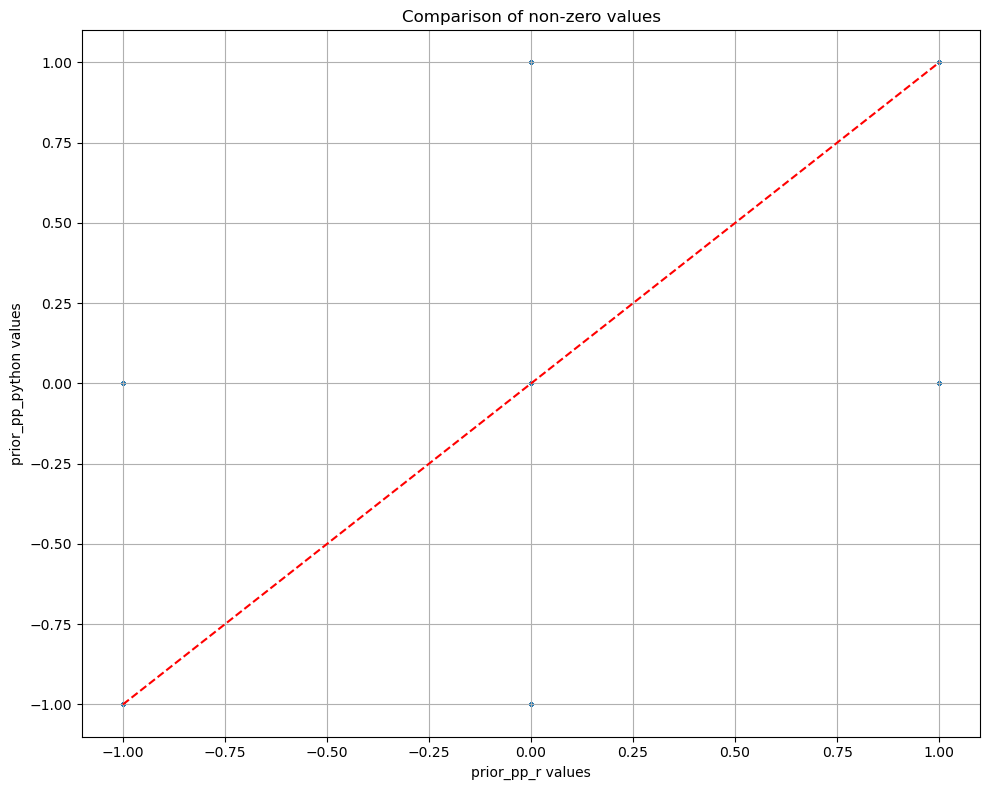

In [7]:
import numpy as np

import matplotlib.pyplot as plt

# Check shapes
print(f"Shape of prior_pp_r: {prior_pp_r.shape}")
print(f"Shape of prior_pp_python: {prior_pp_python.shape}")

# Compare shared indices and columns
shared_indices = sorted(set(prior_pp_r.index).intersection(set(prior_pp_python.index)))
shared_columns = sorted(set(prior_pp_r.columns).intersection(set(prior_pp_python.columns)))
print(f"Number of shared TFs (rows): {len(shared_indices)}")
print(f"Number of shared target genes (columns): {len(shared_columns)}")

# Subset to shared regions
r_sub = prior_pp_r.loc[shared_indices, shared_columns]
py_sub = prior_pp_python.loc[shared_indices, shared_columns]

# Count non-zero entries
nonzero_r = (r_sub != 0).sum().sum()
nonzero_python = (py_sub != 0).sum().sum()
print(f"Non-zero entries in R matrix: {nonzero_r}")
print(f"Non-zero entries in Python matrix: {nonzero_python}")

# Calculate differences
diff = r_sub - py_sub
abs_diff = diff.abs()
mean_abs_diff = abs_diff.values.mean()
max_abs_diff = abs_diff.values.max()
print(f"Mean absolute difference: {mean_abs_diff:.6e}")
print(f"Maximum absolute difference: {max_abs_diff:.6e}")

# Calculate correlation
corr = np.corrcoef(r_sub.values.flatten(), py_sub.values.flatten())[0, 1]
print(f"Correlation between matrices: {corr:.6f}")

# Check sign disagreements
sign_r = np.sign(r_sub)
sign_py = np.sign(py_sub)
sign_disagreements = ((sign_r != sign_py) & (sign_r != 0) & (sign_py != 0)).sum().sum()
print(f"Number of sign disagreements: {sign_disagreements}")

# Edge agreement
r_edges = r_sub != 0
py_edges = py_sub != 0
edge_agreement = (r_edges == py_edges).sum().sum() / r_edges.size
print(f"Edge agreement: {edge_agreement:.4%}")

# Visualization
plt.figure(figsize=(10, 8))
mask = (r_sub != 0) | (py_sub != 0)
if mask.values.sum() > 0:
    plt.scatter(r_sub.values.flatten()[mask.values.flatten()], 
                py_sub.values.flatten()[mask.values.flatten()], 
                alpha=0.5, s=3)
    plt.xlabel("prior_pp_r values")
    plt.ylabel("prior_pp_python values")
    plt.title("Comparison of non-zero values")
    max_val = max(r_sub.values.max(), py_sub.values.max())
    min_val = min(r_sub.values.min(), py_sub.values.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.grid(True)
plt.tight_layout()

In [8]:
prior_pp_r

,A2M,A2ML1,A4GALT,AACS,AANAT,AAR2,AARS2,AATF,ABCA1,ABCA12,...,ZP1,ZP2,ZP3,ZSCAN10,ZSCAN25,ZSCAN9,ZW10,ZXDB,ZXDC,ZYX
ABL1,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0,0,0.0,0
ADNP,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0,0,0.0,0
ADNP2,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0,0,0.0,0
AEBP1,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0,0,0.0,0
AEBP2,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN21,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0,0,0.0,0
ZSCAN26,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0,0,0.0,0
ZSCAN9,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0,0,0.0,0
ZXDA,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,...,0.0,0,0,0,0,0.0,0,0,0.0,0


In [9]:
prior_pp_python

,A2M,A2ML1,A4GALT,AACS,AANAT,AAR2,AARS2,AATF,ABCA1,ABCA12,...,ZP1,ZP2,ZP3,ZSCAN10,ZSCAN25,ZSCAN9,ZW10,ZXDB,ZXDC,ZYX
ABL1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADNP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADNP2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEBP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEBP2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZSCAN26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZSCAN9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZXDA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
len(TF_names), len(TG_names)

(1165, 6356)

In [ ]:
# Define function to count occurrences of specific values
def count_values(matrix):
    # Define thresholds for comparison (to handle floating point precision)
    epsilon = 1e-10
    
    # Initialize counters
    counts = {
        "1": 0,
        "-1": 0,
        "1e-6": 0,
        "-1e-6": 0,
        "0": 0,
        "other": 0
    }
    
    # Flatten the matrix for easier processing
    flat_matrix = matrix.values.flatten()
    
    # Count occurrences
    counts["1"] = np.sum(np.isclose(flat_matrix, 1.0, atol=epsilon))
    counts["-1"] = np.sum(np.isclose(flat_matrix, -1.0, atol=epsilon))
    counts["1e-6"] = np.sum(np.isclose(flat_matrix, 1e-6, atol=epsilon))
    counts["-1e-6"] = np.sum(np.isclose(flat_matrix, -1e-6, atol=epsilon))
    counts["0"] = np.sum(np.isclose(flat_matrix, 0.0, atol=epsilon))
    
    # Count values that don't fall into the above categories
    counts["other"] = flat_matrix.size - sum(counts.values())
    
    return counts

# Count values in Python and R implementations
r_counts = count_values(r_sub)
py_counts = count_values(py_sub)

# Create a comparison table
comparison = pd.DataFrame({
    "R implementation": r_counts,
    "Python implementation": py_counts
})

# Display results
comparison

# Calculate percentages
total_r = r_sub.size
total_py = py_sub.size
print(f"\nPercentage of values:")
print(f"{'Category':<10} {'R':>15} {'Python':>15}")
for category in r_counts:
    r_pct = r_counts[category]
    py_pct = py_counts[category]
    print(f"{category:<10} {r_pct:>15.2f} {py_pct:>15.2f}")


Percentage of values:
Category                 R          Python
1                 18961.00%        18893.00%
-1                 2640.00%         2677.00%
1e-6              18322.00%        18353.00%
-1e-6                 0.00%            0.00%
0               7324705.00%      7324705.00%
other                 0.00%            0.00%


In [ ]:
# Compare P and prior_r
print(f"Shape of prior_r: {prior_r.shape}")
print(f"Shape of P: {P.shape}")

# Compare shared indices and columns
shared_indices = sorted(set(prior_r.index).intersection(set(P.index)))
shared_columns = sorted(set(prior_r.columns).intersection(set(P.columns)))
print(f"Number of shared TFs (rows): {len(shared_indices)}")
print(f"Number of shared target genes (columns): {len(shared_columns)}")

# Subset to shared regions
r_sub = prior_r.loc[shared_indices, shared_columns]
p_sub = P.loc[shared_indices, shared_columns]

# Count non-zero entries
nonzero_r = (r_sub != 0).sum().sum()
nonzero_p = (p_sub != 0).sum().sum()
print(f"Non-zero entries in R matrix: {nonzero_r}")
print(f"Non-zero entries in P matrix: {nonzero_p}")

# Calculate differences
diff = r_sub - p_sub
abs_diff = diff.abs()
mean_abs_diff = abs_diff.values.mean()
max_abs_diff = abs_diff.values.max()
print(f"Mean absolute difference: {mean_abs_diff:.6e}")
print(f"Maximum absolute difference: {max_abs_diff:.6e}")

# Calculate correlation
corr = np.corrcoef(r_sub.values.flatten(), p_sub.values.flatten())[0, 1]
print(f"Correlation between matrices: {corr:.6f}")

# Check sign disagreements
sign_r = np.sign(r_sub)
sign_p = np.sign(p_sub)
sign_disagreements = ((sign_r != sign_p) & (sign_r != 0) & (sign_p != 0)).sum().sum()
print(f"Number of sign disagreements: {sign_disagreements}")

# Edge agreement
r_edges = r_sub != 0
p_edges = p_sub != 0
edge_agreement = (r_edges == p_edges).sum().sum() / r_edges.size
print(f"Edge agreement: {edge_agreement:.4%}")

# Count value distributions
def count_values(matrix):
    # Define thresholds for comparison
    epsilon = 1e-10
    
    # Initialize counters
    counts = {
        "1": 0,
        "-1": 0,
        "1e-6": 0,
        "-1e-6": 0,
        "0": 0,
        "other": 0
    }
    
    flat_matrix = matrix.values.flatten()
    
    counts["1"] = np.sum(np.isclose(flat_matrix, 1.0, atol=epsilon))
    counts["-1"] = np.sum(np.isclose(flat_matrix, -1.0, atol=epsilon))
    counts["1e-6"] = np.sum(np.isclose(flat_matrix, 1e-6, atol=epsilon))
    counts["-1e-6"] = np.sum(np.isclose(flat_matrix, -1e-6, atol=epsilon))
    counts["0"] = np.sum(np.isclose(flat_matrix, 0.0, atol=epsilon))
    counts["other"] = flat_matrix.size - sum(counts.values())
    
    return counts

# Count values in both matrices
r_counts = count_values(r_sub)
p_counts = count_values(p_sub)

# Create a comparison table
comparison = pd.DataFrame({
    "prior_r": r_counts,
    "P": p_counts
})
print("\nValue counts comparison:")
print(comparison)

# Visualization
plt.figure(figsize=(10, 8))
mask = (r_sub != 0) | (p_sub != 0)
if mask.values.sum() > 0:
    plt.scatter(r_sub.values.flatten()[mask.values.flatten()], 
                p_sub.values.flatten()[mask.values.flatten()], 
                alpha=0.5, s=3)
    plt.xlabel("prior_r values")
    plt.ylabel("P values")
    plt.title("Comparison of non-zero values")
    max_val = max(r_sub.values.max(), p_sub.values.max())
    min_val = min(r_sub.values.min(), p_sub.values.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.grid(True)
plt.tight_layout()

Shape of prior_r: (1164, 6327)
Shape of P: (1165, 6356)
Number of shared TFs (rows): 1164
Number of shared target genes (columns): 6327
Non-zero entries in R matrix: 39923
Non-zero entries in P matrix: 39923
Mean absolute difference: 2.342276e-04
Maximum absolute difference: 1.000001e+00
Correlation between matrices: 0.959976
Number of sign disagreements: 257
Edge agreement: 100.0000%

Value counts comparison:
       prior_r        P
1        18961    18893
-1        2640     2677
1e-6     18322    18353
-1e-6        0        0
0      7324705  7324705
other        0        0


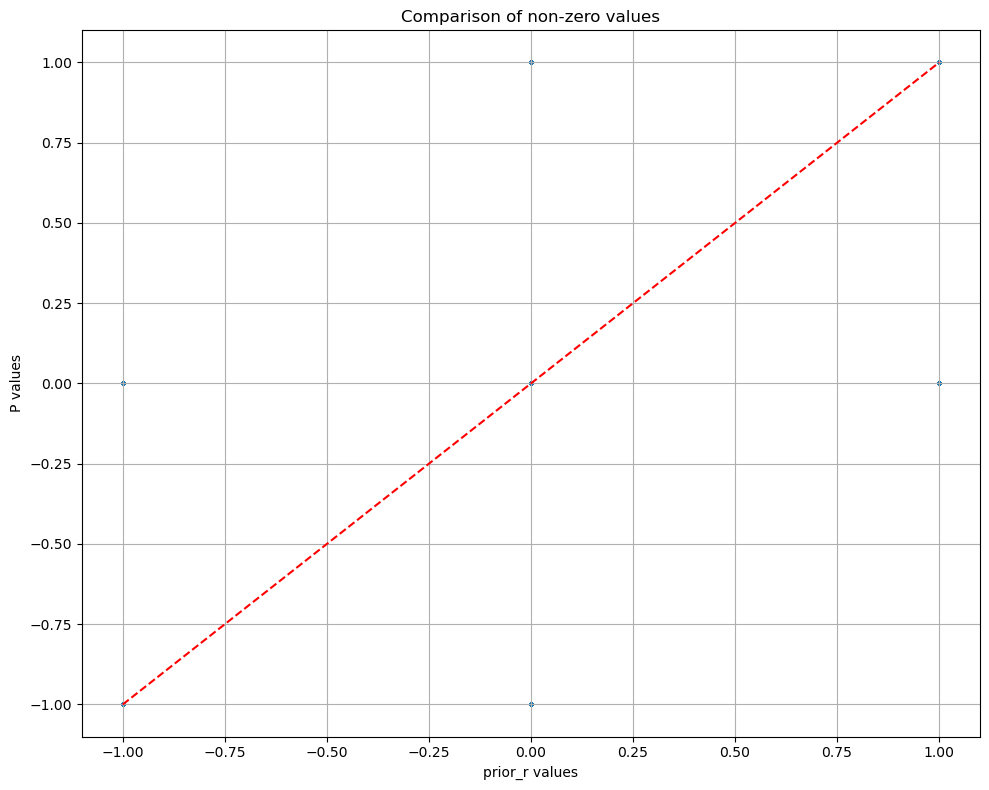

In [15]:
# Compare P and prior_r
print(f"Shape of prior_r: {prior_r.shape}")
print(f"Shape of P: {P.shape}")

# Compare shared indices and columns
shared_indices = sorted(set(prior_r.index).intersection(set(P.index)))
shared_columns = sorted(set(prior_r.columns).intersection(set(P.columns)))
print(f"Number of shared TFs (rows): {len(shared_indices)}")
print(f"Number of shared target genes (columns): {len(shared_columns)}")

# Subset to shared regions
r_sub = prior_r.loc[shared_indices, shared_columns]
p_sub = P.loc[shared_indices, shared_columns]

# Count non-zero entries
nonzero_r = (r_sub != 0).sum().sum()
nonzero_p = (p_sub != 0).sum().sum()
print(f"Non-zero entries in R matrix: {nonzero_r}")
print(f"Non-zero entries in P matrix: {nonzero_p}")

# Calculate differences
diff = r_sub - p_sub
abs_diff = diff.abs()
mean_abs_diff = abs_diff.values.mean()
max_abs_diff = abs_diff.values.max()
print(f"Mean absolute difference: {mean_abs_diff:.6e}")
print(f"Maximum absolute difference: {max_abs_diff:.6e}")

# Calculate correlation
corr = np.corrcoef(r_sub.values.flatten(), p_sub.values.flatten())[0, 1]
print(f"Correlation between matrices: {corr:.6f}")

# Check sign disagreements
sign_r = np.sign(r_sub)
sign_p = np.sign(p_sub)
sign_disagreements = ((sign_r != sign_p) & (sign_r != 0) & (sign_p != 0)).sum().sum()
print(f"Number of sign disagreements: {sign_disagreements}")

# Edge agreement
r_edges = r_sub != 0
p_edges = p_sub != 0
edge_agreement = (r_edges == p_edges).sum().sum() / r_edges.size
print(f"Edge agreement: {edge_agreement:.4%}")

# Count value distributions
def count_values(matrix):
    # Define thresholds for comparison
    epsilon = 1e-10
    
    # Initialize counters
    counts = {
        "1": 0,
        "-1": 0,
        "1e-6": 0,
        "-1e-6": 0,
        "0": 0,
        "other": 0
    }
    
    flat_matrix = matrix.values.flatten()
    
    counts["1"] = np.sum(np.isclose(flat_matrix, 1.0, atol=epsilon))
    counts["-1"] = np.sum(np.isclose(flat_matrix, -1.0, atol=epsilon))
    counts["1e-6"] = np.sum(np.isclose(flat_matrix, 1e-6, atol=epsilon))
    counts["-1e-6"] = np.sum(np.isclose(flat_matrix, -1e-6, atol=epsilon))
    counts["0"] = np.sum(np.isclose(flat_matrix, 0.0, atol=epsilon))
    counts["other"] = flat_matrix.size - sum(counts.values())
    
    return counts

# Count values in both matrices
r_counts = count_values(r_sub)
p_counts = count_values(p_sub)

# Create a comparison table
comparison = pd.DataFrame({
    "prior_r": r_counts,
    "P": p_counts
})
print("\nValue counts comparison:")
print(comparison)

# Visualization
plt.figure(figsize=(10, 8))
mask = (r_sub != 0) | (p_sub != 0)
if mask.values.sum() > 0:
    plt.scatter(r_sub.values.flatten()[mask.values.flatten()], 
                p_sub.values.flatten()[mask.values.flatten()], 
                alpha=0.5, s=3)
    plt.xlabel("prior_r values")
    plt.ylabel("P values")
    plt.title("Comparison of non-zero values")
    max_val = max(r_sub.values.max(), p_sub.values.max())
    min_val = min(r_sub.values.min(), p_sub.values.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.grid(True)
plt.tight_layout()

In [17]:
P

,A2M,A2ML1,A4GALT,AACS,AANAT,AAR2,AARS2,AATF,ABCA1,ABCA12,...,ZP1,ZP2,ZP3,ZSCAN10,ZSCAN25,ZSCAN9,ZW10,ZXDB,ZXDC,ZYX
ABL1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADNP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADNP2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEBP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEBP2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZSCAN26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZSCAN9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZXDA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
prior_pp_python

,A2M,A2ML1,A4GALT,AACS,AANAT,AAR2,AARS2,AATF,ABCA1,ABCA12,...,ZP1,ZP2,ZP3,ZSCAN10,ZSCAN25,ZSCAN9,ZW10,ZXDB,ZXDC,ZYX
ABL1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADNP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADNP2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEBP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AEBP2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZSCAN26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZSCAN9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZXDA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
